In [1]:
import pandas as pd
from pandas import DataFrame
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn.ensemble as ens

In [2]:
data = pd.read_csv('/home/stinger/Documents/!NULP/ІТСС/rgr/PJME_hourly.csv',index_col='Datetime',parse_dates=True)
data.sort_index(inplace=True)
# data = data[(data.index.year == 2017) | (data.index.year == 2016)]
data = data.reset_index()
display(data.head())

,Datetime,PJME_MW
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0


In [3]:
period = []
MAE_error_value = []
RMS_error_value = []



# 
window = 5
columns_data = list(['mean', 'min', 'max', 'std', 'last', 'percentile_25', 'percentile_75', 'median', 'ptp'])
columns_target = list(['x_next'])
train_count = 0.8

sample = data[:]['PJME_MW']

dataframe_data = DataFrame(columns=columns_data)
dataframe_target = DataFrame(columns=columns_target)
sample = sample.values

for i in range(0, len(sample)-window):
    window_sample = sample[i:i+window]
    mean = np.mean(window_sample)
    min = np.min(window_sample)
    max = np.max(window_sample)
    std = np.std(window_sample)
    last = window_sample[-1]
    percentile_25 = np.percentile(window_sample, 25)
    percentile_75 = np.percentile(window_sample, 75)
    median = np.median(window_sample)
    ptp = np.ptp(window_sample)
    dataframe_data.loc[i] = [mean, min, max, std, last, percentile_25, percentile_75, median, ptp]
    dataframe_target.loc[i] = [sample[i+window]]
    # print dataframe_data, dataframe_target

display(dataframe_data.head(),dataframe_target.head())
end = int(train_count*len(dataframe_target))

data_x_test = dataframe_data[end:].values
data_x_train = dataframe_data[:end].values
data_y_test = dataframe_target[end:].values.ravel()
data_y_train = dataframe_target[:end].values.ravel()

,mean,min,max,std,last,percentile_25,percentile_75,median,ptp
0,28794.2,27899.0,30393.0,928.849267,28057.0,28057.0,29265.0,28357.0,2494.0
1,28446.4,27899.0,29265.0,484.246879,28654.0,28057.0,28654.0,28357.0,1366.0
2,28455.0,27899.0,29308.0,498.869522,29308.0,28057.0,28654.0,28357.0,1409.0
3,28702.6,27899.0,29595.0,667.505985,29595.0,28057.0,29308.0,28654.0,1696.0
4,29111.4,28057.0,29943.0,676.025621,29943.0,28654.0,29595.0,29308.0,1886.0


,x_next
0,28654.0
1,29308.0
2,29595.0
3,29943.0
4,30692.0


In [34]:
# model = ens.RandomForestRegressor(random_state=22,n_estimators=10, max_depth=5) #('min errors MAE', 16.320578144289708)('error MAE', 418.17633481308712)
# model = ens.AdaBoostRegressor(lm.PassiveAggressiveRegressor(),random_state=22, loss='exponential') #('min errors MAE', 18.699589988614836)('error MAE', 146.28983220030995)
model = ens.BaggingRegressor(n_estimators=100, random_state=22) #('min errors MAE', 12.862820067293704)('error MAE', 321.29314407920509)
# model = ens.ExtraTreesRegressor(random_state=22,n_estimators=6, max_depth=5)# ('min errors MAE', 13.716582157462417)('error MAE', 166.4425884557231)
# model = ens.GradientBoostingRegressor(random_state=22)#('min errors MAE', 9.8312045757831292)('error MAE', 198.42956089770328)

model.fit(data_x_train, data_y_train)
predict = model.predict(data_x_test)

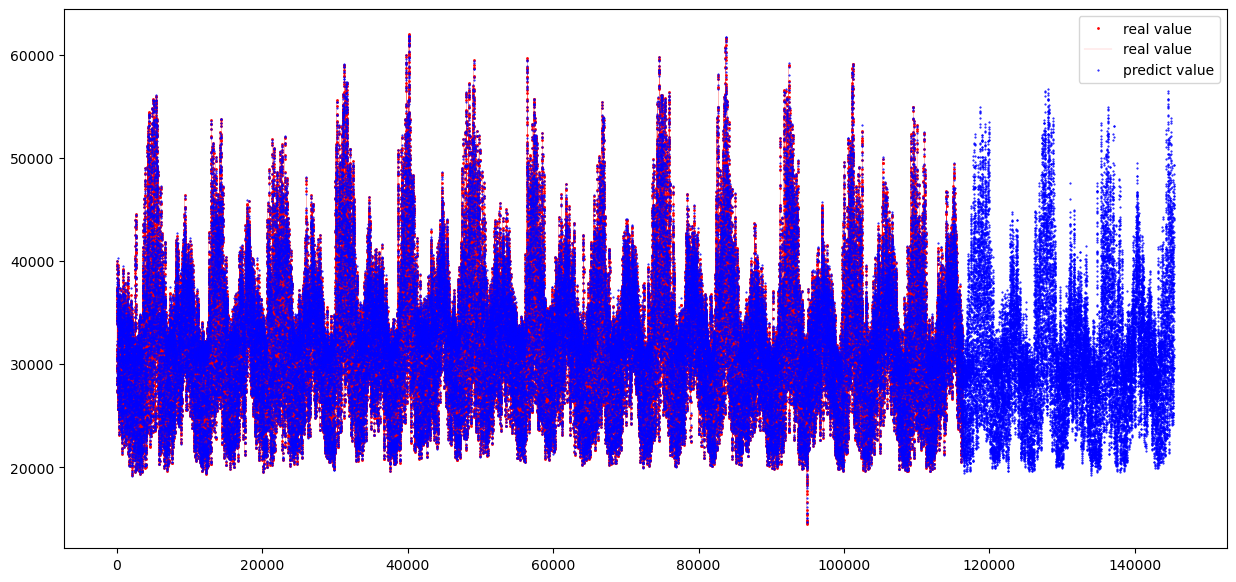

errors MAE 0.012642177957853681
errors RMSE 3.436610460975821


In [35]:
plt.figure(figsize=(15,7))
plt.plot(dataframe_target[:end].values.ravel(), 'or', label='real value', markersize = 1)
plt.plot(dataframe_target[:end].values.ravel(), 'red', label='real value',linewidth=0.1)
plt.plot(model.predict(dataframe_data[:].values), 'ob', label='predict value', markersize = 0.5)
# plt.plot(model.predict(dataframe_data[:].values), 'blue', label='predict value')
plt.legend(loc='upper right')
plt.show()

if np.mean(data_y_test) > 0:
    MAE_error_value = metrics.mean_absolute_error(predict, data_y_test) / np.mean(data_y_test)
    RMS_error_value = np.sqrt(metrics.mean_squared_error(predict, data_y_test) / np.mean(data_y_test))
print('errors MAE', MAE_error_value)
print('errors RMSE', RMS_error_value)

In [6]:
model.get_params()

{'bootstrap': True,
 'bootstrap_features': False,
 'estimator': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 22,
 'verbose': 0,
 'warm_start': False}

In [7]:
from sklearn.model_selection import GridSearchCV

In [12]:
%%time
param_grid = {
    'random_state': [22],
    'n_estimators': [2, 5, 10, 20, 50, 100, 200]
}
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    scoring='neg_mean_absolute_error', 
                    cv=5,
                    verbose = 3,
                    return_train_score=True,
                    n_jobs = 1)
grid.fit(data_x_train, data_y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END n_estimators=2, random_state=22;, score=(train=-196.674, test=-513.348) total time=   1.7s
[CV 2/5] END n_estimators=2, random_state=22;, score=(train=-199.182, test=-510.541) total time=   1.7s
[CV 3/5] END n_estimators=2, random_state=22;, score=(train=-201.356, test=-490.947) total time=   1.7s
[CV 4/5] END n_estimators=2, random_state=22;, score=(train=-200.704, test=-504.110) total time=   1.7s
[CV 5/5] END n_estimators=2, random_state=22;, score=(train=-197.877, test=-531.040) total time=   1.7s
[CV 1/5] END n_estimators=5, random_state=22;, score=(train=-180.240, test=-465.431) total time=   4.1s
[CV 2/5] END n_estimators=5, random_state=22;, score=(train=-181.649, test=-459.072) total time=   4.2s
[CV 3/5] END n_estimators=5, random_state=22;, score=(train=-183.870, test=-442.308) total time=   4.1s
[CV 4/5] END n_estimators=5, random_state=22;, score=(train=-182.927, test=-449.658) total time=   4.2s
[CV 

In [15]:
%%time
param_grid = {
    'random_state': [22],
    'max_samples': [x / 10 for x in range(1, 11)]
}
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    scoring='neg_mean_absolute_error', 
                    cv=5,
                    verbose = 3,
                    return_train_score=True,
                    n_jobs = -1)
grid.fit(data_x_train, data_y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best parameters are {'max_samples': 1.0, 'random_state': 22} with a score of -435.07
CPU times: user 10.3 s, sys: 129 ms, total: 10.4 s
Wall time: 1min 2s


In [16]:
%%time
param_grid = {
    'random_state': [22],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.90, 0.92, 0.95, 1.0]
}
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    scoring='neg_mean_absolute_error', 
                    cv=5,
                    verbose = 3,
                    return_train_score=True,
                    n_jobs = -1)
grid.fit(data_x_train, data_y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 13 candidates, totalling 65 fits
The best parameters are {'max_features': 1.0, 'random_state': 22} with a score of -435.07
CPU times: user 10.3 s, sys: 53.3 ms, total: 10.4 s
Wall time: 1min 19s


In [21]:
%%time
param_grid = {
    'random_state': [22],
    'n_estimators': [50, 100, 200, 300],
    'max_samples': [x / 10 for x in range(1, 11, 5)],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    scoring='neg_mean_absolute_error', 
                    cv=5,
                    verbose = 3,
                    return_train_score=True,
                    n_jobs = -1)
grid.fit(data_x_train, data_y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 5/5] END bootstrap=True, bootstrap_features=True, max_samples=0.1, n_estimators=50, random_state=22;, score=(train=-721.669, test=-776.816) total time=   8.4s
[CV 1/5] END bootstrap=True, bootstrap_features=True, max_samples=0.1, n_estimators=200, random_state=22;, score=(train=-851.109, test=-968.161) total time=  34.2s
[CV 4/5] END bootstrap=True, bootstrap_features=True, max_samples=0.1, n_estimators=300, random_state=22;, score=(train=-834.866, test=-948.739) total time=  50.4s
[CV 2/5] END bootstrap=True, bootstrap_features=True, max_samples=0.1, n_estimators=50, random_state=22;, score=(train=-724.393, test=-803.432) total time=   8.4s
[CV 4/5] END bootstrap=True, bootstrap_features=True, max_samples=0.1, n_estimators=100, random_state=22;, score=(train=-809.266, test=-918.340) total time=  16.7s
[CV 2/5] END bootstrap=True, bootstrap_features=True, max_samples=0.1, n_estimators=300, random_state=22;, score=(train=

In [22]:
param_grid = {'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.6, 'n_estimators': 300, 'random_state': 22}

In [26]:
model = ens.BaggingRegressor(bootstrap= False, bootstrap_features= False, max_samples= 0.6, n_estimators= 300, random_state= 22)
model.fit(data_x_train, data_y_train)
predict = model.predict(data_x_test)